# NYC Neighborhood Livability Analysis

Analysis of NYC neighborhoods at census tract level, integrating housing costs, transit accessibility, and urban quality indicators.

**Quick Start:** If you have `master_tract.csv`, start at Section 2.

## 1. Setup

In [5]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn folium -q

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from sklearn.preprocessing import MinMaxScaler

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

### Census Tract to Neighborhood Mapping

Create a simplified mapping from census tracts to recognizable neighborhood names based on NYC Planning's Neighborhood Tabulation Areas (NTAs).

In [7]:
def get_neighborhood_from_tract(boroct):
    """
    Map census tract codes to approximate neighborhood names.
    Note: This is a simplified mapping for major neighborhoods.
    Census tract codes format: BBGGGCCC where BB=borough, GGG=tract, CCC=suffix
    """
    try:
        tract_str = str(int(boroct))
        if len(tract_str) < 6:
            tract_str = tract_str.zfill(6)

        boro = int(tract_str[0])
        tract = int(tract_str[1:4])

        # Manhattan (1)
        if boro == 1:
            if tract <= 30: return "Financial District/Battery Park"
            elif tract <= 60: return "Lower East Side/Chinatown"
            elif tract <= 90: return "SoHo/TriBeCa/Greenwich Village"
            elif tract <= 120: return "Chelsea/Flatiron/Gramercy"
            elif tract <= 150: return "Midtown West"
            elif tract <= 180: return "Midtown East"
            elif tract <= 210: return "Upper West Side"
            elif tract <= 240: return "Upper East Side"
            elif tract <= 270: return "Central Harlem"
            elif tract <= 300: return "East Harlem"
            elif tract <= 350: return "Washington Heights"
            else: return "Inwood/Marble Hill"

        # Bronx (2)
        elif boro == 2:
            if tract <= 50: return "Mott Haven/Hunts Point"
            elif tract <= 100: return "Morrisania/Crotona"
            elif tract <= 150: return "Highbridge/Concourse"
            elif tract <= 200: return "Fordham/University Heights"
            elif tract <= 250: return "Kingsbridge/Riverdale"
            elif tract <= 300: return "Belmont/East Tremont"
            elif tract <= 350: return "Pelham Parkway/Van Nest"
            elif tract <= 400: return "Throgs Neck/Co-op City"
            else: return "Bronx (Other)"

        # Brooklyn (3)
        elif boro == 3:
            if tract <= 50: return "Downtown Brooklyn/Brooklyn Heights"
            elif tract <= 100: return "Fort Greene/Clinton Hill"
            elif tract <= 150: return "Bedford-Stuyvesant"
            elif tract <= 200: return "Bushwick/East New York"
            elif tract <= 250: return "Williamsburg/Greenpoint"
            elif tract <= 350: return "Park Slope/Gowanus"
            elif tract <= 450: return "Sunset Park/Borough Park"
            elif tract <= 550: return "Bay Ridge/Dyker Heights"
            elif tract <= 650: return "Flatbush/Midwood"
            elif tract <= 750: return "Crown Heights/Prospect Heights"
            elif tract <= 850: return "East Flatbush/Flatlands"
            elif tract <= 950: return "Canarsie/Bergen Beach"
            elif tract <= 1050: return "Coney Island/Gravesend"
            else: return "Brooklyn (Other)"

        # Queens (4)
        elif boro == 4:
            if tract <= 50: return "Long Island City/Astoria"
            elif tract <= 150: return "Sunnyside/Woodside"
            elif tract <= 250: return "Jackson Heights/Elmhurst"
            elif tract <= 350: return "Corona/Flushing"
            elif tract <= 450: return "Forest Hills/Rego Park"
            elif tract <= 550: return "Jamaica/Hollis"
            elif tract <= 650: return "Queens Village/Bellerose"
            elif tract <= 750: return "Ridgewood/Glendale"
            elif tract <= 850: return "Ozone Park/Howard Beach"
            elif tract <= 950: return "Rockaway"
            else: return "Queens (Other)"

        # Staten Island (5)
        elif boro == 5:
            if tract <= 100: return "North Shore (St. George/New Brighton)"
            elif tract <= 200: return "Mid-Island (New Springville/Bulls Head)"
            elif tract <= 300: return "South Shore (Great Kills/Tottenville)"
            else: return "Staten Island (Other)"

        else:
            return "Unknown"
    except:
        return "Unknown"

# Test the function
print("Sample neighborhood mappings:")
print(f"1000100 -> {get_neighborhood_from_tract(1000100)}")  # Manhattan
print(f"3000100 -> {get_neighborhood_from_tract(3000100)}")  # Brooklyn
print(f"4000100 -> {get_neighborhood_from_tract(4000100)}")  # Queens

Sample neighborhood mappings:
1000100 -> Financial District/Battery Park
3000100 -> Downtown Brooklyn/Brooklyn Heights
4000100 -> Long Island City/Astoria


## 2. Load Data

In [8]:
# Update this path to your data location
data_path = 'master_tract.csv'

df = pd.read_csv(data_path)

# Add neighborhood names
df['Neighborhood'] = df['boroct2020'].apply(get_neighborhood_from_tract)

print(f"Loaded {len(df):,} census tracts")
print(f"Boroughs: {', '.join(df['Borough'].unique())}")
print(f"Price range: ${df['Price'].min():,.0f} - ${df['Price'].max():,.0f}")
print(f"\nUnique neighborhoods identified: {df['Neighborhood'].nunique()}")
print(f"\nSample neighborhoods:")
print(df.groupby('Neighborhood')['Price'].agg(['count', 'median']).sort_values('median', ascending=False).head(10))

Loaded 1,947 census tracts
Boroughs: Manhattan, Bronx, Brooklyn, Queens, Staten Island
Price range: $1,700 - $5,795

Unique neighborhoods identified: 12

Sample neighborhoods:
                                       count   median
Neighborhood                                         
Lower East Side/Chinatown                  4  5168.25
Financial District/Battery Park          295  4800.00
Bedford-Stuyvesant                        69  3300.00
North Shore (St. George/New Brighton)     15  3200.00
Downtown Brooklyn/Brooklyn Heights       463  3185.00
Morrisania/Crotona                         2  3150.00
Fort Greene/Clinton Hill                 199  3000.00
Jackson Heights/Elmhurst                   4  2867.00
Long Island City/Astoria                 322  2850.00
Sunnyside/Woodside                       305  2825.00


## 3. Data Exploration

In [9]:
# Basic statistics
print("Dataset Overview:")
print(f"Total tracts: {len(df):,}")
print(f"\nMissing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Key metrics summary
print("\nKey Metrics Summary:")
key_cols = ['Price', 'total_crimes', 'noise_complaint_count',
            'total_mta_ridership', 'total_citibike_trips', 'total_businesses']
print(df[key_cols].describe())

Dataset Overview:
Total tracts: 1,947

Missing values:
Series([], dtype: int64)

Key Metrics Summary:
             Price  total_crimes  noise_complaint_count  total_mta_ridership  \
count  1947.000000   1947.000000            1947.000000         1.947000e+03   
mean   3212.138932     21.427838             493.446328         1.803504e+04   
std     849.468282     22.629695             785.761398         6.917751e+04   
min    1700.000000      0.000000               1.000000         0.000000e+00   
25%    2750.000000      7.000000              85.000000         0.000000e+00   
50%    3000.000000     14.000000             228.000000         0.000000e+00   
75%    3400.000000     27.000000             570.500000         0.000000e+00   
max    5795.000000    309.000000            8832.000000         1.482850e+06   

       total_citibike_trips  total_businesses  
count           1947.000000            1947.0  
mean             496.244479               0.0  
std             1156.671561      

<Figure size 1200x600 with 0 Axes>

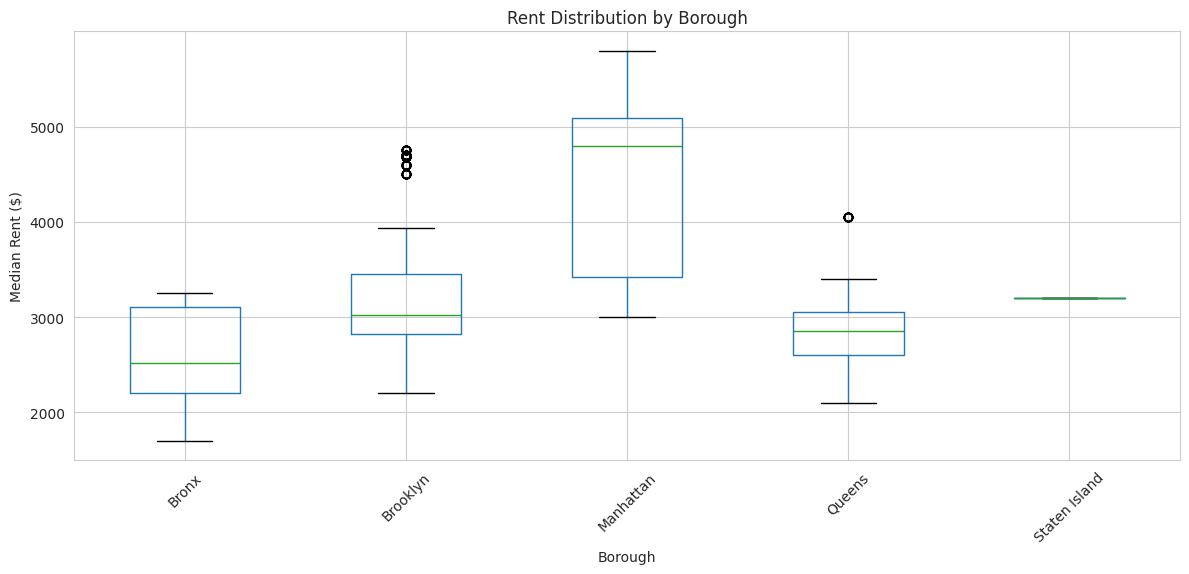

In [10]:
# Distribution of rent by borough
plt.figure(figsize=(12, 6))
df.boxplot(column='Price', by='Borough', figsize=(12, 6))
plt.title('Rent Distribution by Borough')
plt.suptitle('')
plt.ylabel('Median Rent ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Calculate Composite Indices

In [11]:
# Initialize scaler (0-100 range)
scaler = MinMaxScaler(feature_range=(0, 100))

# (1) Convenience Score: Transit + Amenities
accessibility_components = []

if 'total_mta_ridership' in df.columns:
    mta_norm = scaler.fit_transform(df[['total_mta_ridership']].fillna(0))
    accessibility_components.append(mta_norm.flatten())

if 'total_citibike_trips' in df.columns:
    bike_norm = scaler.fit_transform(df[['total_citibike_trips']].fillna(0))
    accessibility_components.append(bike_norm.flatten())

if 'total_businesses' in df.columns:
    business_norm = scaler.fit_transform(df[['total_businesses']].fillna(0))
    accessibility_components.append(business_norm.flatten())

df['convenience_score'] = np.mean(accessibility_components, axis=0) if accessibility_components else 0

# (2) Livability Score: Low Crime + Low Noise
crime_norm = scaler.fit_transform(df[['total_crimes']].fillna(0)).flatten()
noise_norm = scaler.fit_transform(df[['noise_complaint_count']].fillna(0)).flatten()
urban_stress = (crime_norm + noise_norm) / 2
df['livability_score'] = 100 - urban_stress

# (3) Affordability Score: Inverse of Rent
rent_norm = scaler.fit_transform(df[['Price']].fillna(df['Price'].median())).flatten()
df['affordability_score'] = 100 - rent_norm

print("Indices calculated:")
print(f"Convenience: {df['convenience_score'].min():.1f} - {df['convenience_score'].max():.1f}")
print(f"Livability: {df['livability_score'].min():.1f} - {df['livability_score'].max():.1f}")
print(f"Affordability: {df['affordability_score'].min():.1f} - {df['affordability_score'].max():.1f}")

Indices calculated:
Convenience: 0.0 - 50.9
Livability: 40.9 - 100.0
Affordability: 0.0 - 100.0


## 5. Visualization

/tmp/ipython-input-84854483.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 0].boxplot([df[df['Borough'] == b]['Price'].dropna() for b in boroughs],
/tmp/ipython-input-84854483.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot([df[df['Borough'] == b]['convenience_score'].dropna() for b in boroughs],
/tmp/ipython-input-84854483.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df[df['Borough'] == b]['livability_score'].dropna() for b in boroughs],
/tmp/ipython-input-84854483.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed

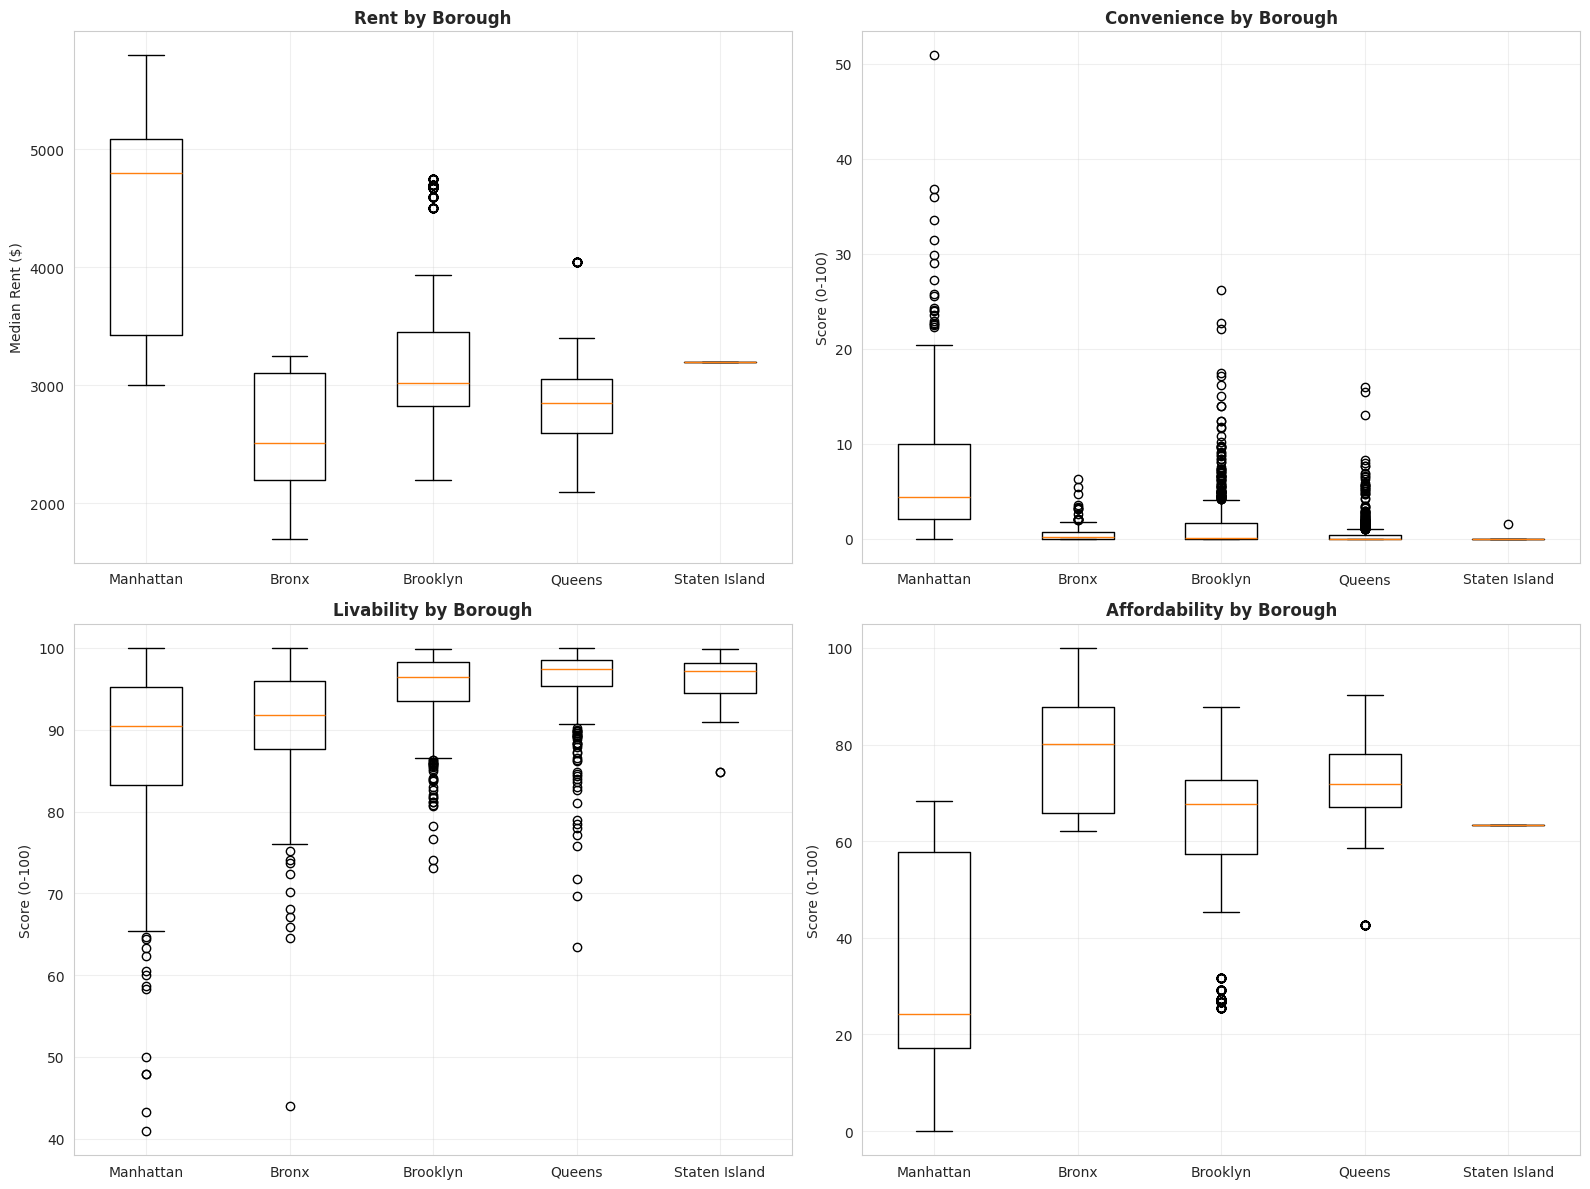

In [12]:
# Index distributions by borough
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

boroughs = df['Borough'].unique()

# Price
axes[0, 0].boxplot([df[df['Borough'] == b]['Price'].dropna() for b in boroughs],
                    labels=boroughs)
axes[0, 0].set_title('Rent by Borough', fontweight='bold')
axes[0, 0].set_ylabel('Median Rent ($)')
axes[0, 0].grid(True, alpha=0.3)

# Convenience
axes[0, 1].boxplot([df[df['Borough'] == b]['convenience_score'].dropna() for b in boroughs],
                    labels=boroughs)
axes[0, 1].set_title('Convenience by Borough', fontweight='bold')
axes[0, 1].set_ylabel('Score (0-100)')
axes[0, 1].grid(True, alpha=0.3)

# Livability
axes[1, 0].boxplot([df[df['Borough'] == b]['livability_score'].dropna() for b in boroughs],
                    labels=boroughs)
axes[1, 0].set_title('Livability by Borough', fontweight='bold')
axes[1, 0].set_ylabel('Score (0-100)')
axes[1, 0].grid(True, alpha=0.3)

# Affordability
axes[1, 1].boxplot([df[df['Borough'] == b]['affordability_score'].dropna() for b in boroughs],
                    labels=boroughs)
axes[1, 1].set_title('Affordability by Borough', fontweight='bold')
axes[1, 1].set_ylabel('Score (0-100)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

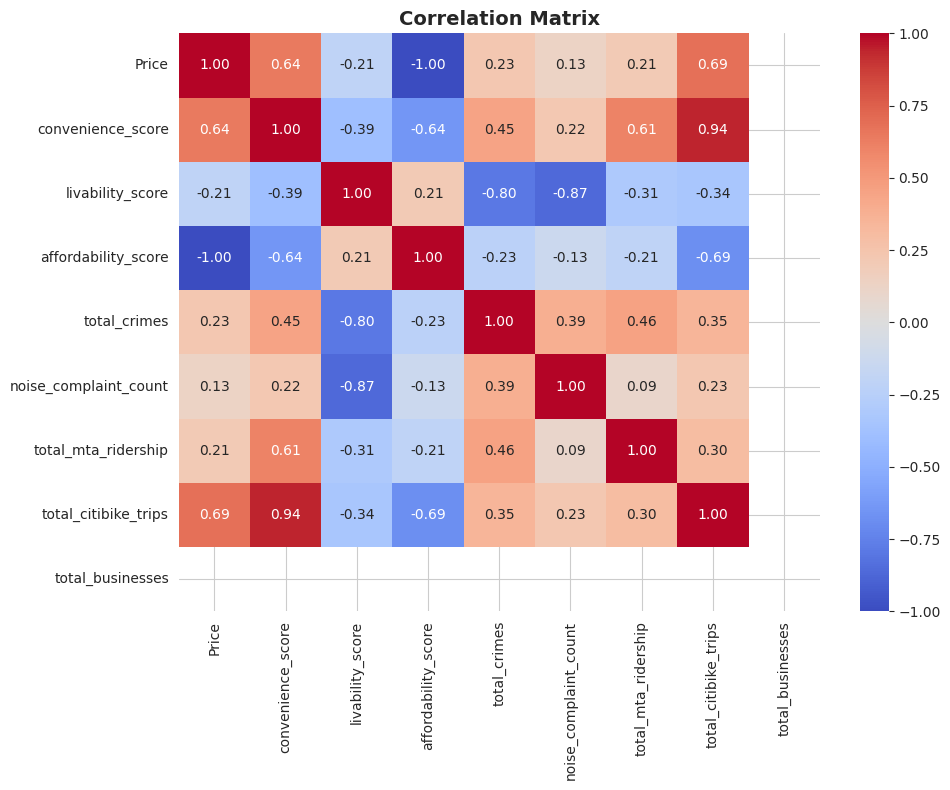


Correlations with Rent:
Price                    1.000000
total_citibike_trips     0.685289
convenience_score        0.644048
total_crimes             0.229554
total_mta_ridership      0.206138
noise_complaint_count    0.126317
livability_score        -0.207255
affordability_score     -1.000000
total_businesses              NaN
Name: Price, dtype: float64


In [13]:
# Correlation with rent
correlation_cols = ['Price', 'convenience_score', 'livability_score', 'affordability_score',
                    'total_crimes', 'noise_complaint_count', 'total_mta_ridership',
                    'total_citibike_trips', 'total_businesses']

corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

# Key correlations with Price
print("\nCorrelations with Rent:")
print(corr_matrix['Price'].sort_values(ascending=False))

## 7. Neighborhood Rankings

In [14]:
# Define thresholds for "high" scores
convenience_threshold = df['convenience_score'].quantile(0.75)
livability_threshold = df['livability_score'].quantile(0.75)
affordability_threshold = df['affordability_score'].quantile(0.75)

# Find neighborhoods meeting different criteria
high_convenience = df[df['convenience_score'] >= convenience_threshold]
high_livability = df[df['livability_score'] >= livability_threshold]
high_affordability = df[df['affordability_score'] >= affordability_threshold]

# Best overall: high convenience + high livability
best_overall = df[(df['convenience_score'] >= convenience_threshold) &
                  (df['livability_score'] >= livability_threshold)]

# Hidden gems: high livability + high affordability
hidden_gems = df[(df['livability_score'] >= livability_threshold) &
                 (df['affordability_score'] >= affordability_threshold)]

print(f"High Convenience Tracts: {len(high_convenience)} ({len(high_convenience)/len(df)*100:.1f}%)")
print(f"High Livability Tracts: {len(high_livability)} ({len(high_livability)/len(df)*100:.1f}%)")
print(f"High Affordability Tracts: {len(high_affordability)} ({len(high_affordability)/len(df)*100:.1f}%)")
print(f"\nBest Overall (High Convenience + High Livability): {len(best_overall)} ({len(best_overall)/len(df)*100:.1f}%)")
print(f"Hidden Gems (High Livability + High Affordability): {len(hidden_gems)} ({len(hidden_gems)/len(df)*100:.1f}%)")

High Convenience Tracts: 487 (25.0%)
High Livability Tracts: 487 (25.0%)
High Affordability Tracts: 534 (27.4%)

Best Overall (High Convenience + High Livability): 34 (1.7%)
Hidden Gems (High Livability + High Affordability): 158 (8.1%)


In [15]:
# Top 10 by combined convenience + livability
df['combined_score'] = (df['convenience_score'] + df['livability_score']) / 2

top_neighborhoods = df.nlargest(10, 'combined_score')[[
    'boroct2020', 'Neighborhood', 'Borough', 'Price', 'convenience_score',
    'livability_score', 'affordability_score', 'combined_score'
]]

print("\nTop 10 Census Tracts (Convenience + Livability):")
print(top_neighborhoods.to_string(index=False))

# Aggregate by neighborhood
neighborhood_agg = df.groupby('Neighborhood').agg({
    'Price': 'median',
    'convenience_score': 'mean',
    'livability_score': 'mean',
    'affordability_score': 'mean',
    'combined_score': 'mean',
    'boroct2020': 'count'
}).rename(columns={'boroct2020': 'tract_count'}).round(1)

neighborhood_agg['Price'] = neighborhood_agg['Price'].round(0)

print("\n\nTop 10 Neighborhoods by Combined Score (Averaged across tracts):")
print(neighborhood_agg.nlargest(10, 'combined_score').to_string())


Top 10 Census Tracts (Convenience + Livability):
 boroct2020                       Neighborhood   Borough  Price  convenience_score  livability_score  affordability_score  combined_score
    1003700    Financial District/Battery Park Manhattan 5795.0          36.006834         89.831514             0.000000       62.919174
    1009903    Financial District/Battery Park Manhattan 4915.0          27.265623         93.190489            21.489621       60.228056
    1009200    Financial District/Battery Park Manhattan 4900.0          31.469142         88.427608            21.855922       59.948375
    1031703          Lower East Side/Chinatown Manhattan 5249.0          25.713491         91.530351            13.333333       58.621921
    1005600    Financial District/Battery Park Manhattan 5527.0          23.567513         91.950539             6.544567       57.759026
    3017700 Downtown Brooklyn/Brooklyn Heights  Brooklyn 3914.0          22.743794         91.851319            45.934066 

## 8. Interactive Maps

Visualize top neighborhoods and their characteristics on an interactive map.

In [16]:
# Create sample coordinates for visualization
# Note: For production, you'd want actual census tract centroids
# This creates approximate locations based on borough centers

borough_centers = {
    'Manhattan': (40.7831, -73.9712),
    'Brooklyn': (40.6782, -73.9442),
    'Queens': (40.7282, -73.7949),
    'Bronx': (40.8448, -73.8648),
    'Staten Island': (40.5795, -74.1502)
}

# Get top 20 neighborhoods by combined score
top_20 = df.nlargest(20, 'combined_score').copy()

# Add approximate coordinates (offset from borough center)
np.random.seed(42)
top_20['lat'] = top_20['Borough'].apply(lambda x: borough_centers[x][0] + np.random.uniform(-0.05, 0.05))
top_20['lon'] = top_20['Borough'].apply(lambda x: borough_centers[x][1] + np.random.uniform(-0.05, 0.05))

# Create base map centered on NYC
nyc_map = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=11,
    tiles='CartoDB positron'
)

# Add markers for top neighborhoods
for idx, row in top_20.iterrows():
    # Color based on combined score
    if row['combined_score'] >= 80:
        color = 'darkgreen'
    elif row['combined_score'] >= 70:
        color = 'green'
    elif row['combined_score'] >= 60:
        color = 'lightgreen'
    else:
        color = 'orange'

    popup_text = f"""
    <b>{row['Neighborhood']}</b><br>
    <b>Borough:</b> {row['Borough']}<br>
    <b>Median Rent:</b> ${row['Price']:,.0f}<br>
    <hr>
    <b>Convenience:</b> {row['convenience_score']:.1f}/100<br>
    <b>Livability:</b> {row['livability_score']:.1f}/100<br>
    <b>Affordability:</b> {row['affordability_score']:.1f}/100<br>
    <b>Combined:</b> {row['combined_score']:.1f}/100
    """

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=8,
        popup=folium.Popup(popup_text, max_width=250),
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.7,
        weight=2
    ).add_to(nyc_map)

# Add legend
legend_html = '''
<div style="position: fixed;
            bottom: 50px; right: 50px; width: 200px; height: 140px;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; border-radius: 5px; padding: 10px">
<p style="margin-bottom: 8px;"><b>Combined Score</b></p>
<p style="margin: 4px;"><i class="fa fa-circle" style="color:darkgreen"></i> 80-100 (Excellent)</p>
<p style="margin: 4px;"><i class="fa fa-circle" style="color:green"></i> 70-79 (Good)</p>
<p style="margin: 4px;"><i class="fa fa-circle" style="color:lightgreen"></i> 60-69 (Fair)</p>
<p style="margin: 4px;"><i class="fa fa-circle" style="color:orange"></i> < 60 (Lower)</p>
</div>
'''
nyc_map.get_root().html.add_child(folium.Element(legend_html))

# Display map
print("Interactive map of top 20 census tracts by combined score:")
nyc_map

Interactive map of top 20 census tracts by combined score:


### Create Heatmap by Score Type

In [17]:
# Create convenience score heatmap
def create_score_map(df, score_column, title):
    """
    Create an interactive map showing score distribution.
    """
    # Get top 50 for better visualization
    top_areas = df.nlargest(50, score_column).copy()

    # Add approximate coordinates
    np.random.seed(42)
    top_areas['lat'] = top_areas['Borough'].apply(
        lambda x: borough_centers[x][0] + np.random.uniform(-0.06, 0.06)
    )
    top_areas['lon'] = top_areas['Borough'].apply(
        lambda x: borough_centers[x][1] + np.random.uniform(-0.06, 0.06)
    )

    # Create map
    m = folium.Map(
        location=[40.7128, -74.0060],
        zoom_start=11,
        tiles='CartoDB positron'
    )

    # Add heatmap layer
    heat_data = [[row['lat'], row['lon'], row[score_column]/100]
                 for idx, row in top_areas.iterrows()]

    plugins.HeatMap(heat_data, radius=15, blur=25, max_zoom=13).add_to(m)

    # Add title
    title_html = f'''
    <div style="position: fixed;
                top: 10px; left: 50px; width: 300px; height: 50px;
                background-color: white; z-index:9999; font-size:16px;
                border:2px solid grey; border-radius: 5px; padding: 10px;
                text-align: center;">
    <b>{title}</b><br>
    <small>Top 50 Census Tracts</small>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(title_html))

    return m

# Create maps for each score
print("\nConvenience Score Distribution:")
convenience_map = create_score_map(df, 'convenience_score', 'Convenience Score Heatmap')
convenience_map


Convenience Score Distribution:


In [18]:
print("\nLivability Score Distribution:")
livability_map = create_score_map(df, 'livability_score', 'Livability Score Heatmap')
livability_map


Livability Score Distribution:


In [19]:
print("\nAffordability Score Distribution:")
affordability_map = create_score_map(df, 'affordability_score', 'Affordability Score Heatmap')
affordability_map


Affordability Score Distribution:


## 9. Export Results

In [20]:
# Save analyzed data
output_df = df[['boroct2020', 'Neighborhood', 'Borough', 'Price',
                'convenience_score', 'livability_score', 'affordability_score',
                'combined_score', 'total_crimes', 'noise_complaint_count',
                'total_mta_ridership', 'total_citibike_trips', 'total_businesses']]

output_df.to_csv('nyc_neighborhood_analysis_results.csv', index=False)
print("Results saved to: nyc_neighborhood_analysis_results.csv")

# Save neighborhood-level aggregates
neighborhood_agg.to_csv('nyc_neighborhood_summary.csv')
print("Neighborhood summary saved to: nyc_neighborhood_summary.csv")

# Save maps
nyc_map.save('top_neighborhoods_map.html')
convenience_map.save('convenience_heatmap.html')
livability_map.save('livability_heatmap.html')
affordability_map.save('affordability_heatmap.html')
print("\nInteractive maps saved:")
print("  - top_neighborhoods_map.html")
print("  - convenience_heatmap.html")
print("  - livability_heatmap.html")
print("  - affordability_heatmap.html")

Results saved to: nyc_neighborhood_analysis_results.csv
Neighborhood summary saved to: nyc_neighborhood_summary.csv

Interactive maps saved:
  - top_neighborhoods_map.html
  - convenience_heatmap.html
  - livability_heatmap.html
  - affordability_heatmap.html
